## Importing Libraries

In [ ]:
import time
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import numpy as np
from torchvision import transforms
import torch
from tqdm.auto import tqdm
from spikingjelly.activation_based import neuron, functional, surrogate , encoding , layer
import math
from numba import jit , prange
from numba.typed import List
import random

## device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data and Transformation

In [ ]:
transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.2860, 0.3530),
        ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.2860, 0.3530),
        ])

In [ ]:
import torch
import torchvision
import numpy as np

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Download datasets
train_dataset = torchvision.datasets.FashionMNIST(
    root="Kherad Finale /data",
    train=True,
    transform=transform_train,
    download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='Kherad Finale /data',
    train=False,
    transform=transform_test,
    download=True
)

# DataLoaders
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

## defining Network

In [ ]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.flatten = layer.Flatten()
        self.fc1 = layer.Linear(28*28, 50, bias=False) # Input
        self.lif1 = neuron.LIFNode(tau=3.0, surrogate_function=surrogate.ATan())
        self.fc2 = layer.Linear(50, 10, bias=False) # Input
        self.lif2 = neuron.LIFNode(tau=3.0, surrogate_function=surrogate.ATan())
        

    def forward(self, x: torch.Tensor):

        x = self.flatten(x)
        x = self.lif1(self.fc1(x))
        self.s_layer1 = x
        x = self.lif2(self.fc2(x))
        self.s_layer2 = x
        
        '''
        x = self.lif3(self.fc3(x))
        self.s_layer3 = x
        x = self.lif4(self.fc4(x))
        '''
        
        return x , self.s_layer1

## Writing record and saving model 

In [ ]:
def write_record_to_file(path , name , epoch, accuracy, number_of_spikes, loss):
    with open(path + f"{name}_record.txt", "a") as f:
        f.write(f"{epoch}, {accuracy}, {number_of_spikes}, {loss}\n")

In [ ]:
def write_model_to_file(path , name , lambda1):
    with open(path + f"{name}_model.txt", "a") as f:
        f.write(f"{name}, {lambda1}\n")

## Train Synchrony

In [ ]:
class Train_Synchrony():

    def __init__(self , network , T = 30 , epochs = 60 , window_size = 2 , jump = 3  , limit = 30 , lambda_synch = 4*10**-5 , name = "synchrony" , dataloader = train_data_loader):

        
        self.Numberofspikes = []
        self.trainacc= []
        self.last_epoch_record= []
        self.last_epoch_images= []
        self.last_epoch_labels= []
        self.window_size = window_size
        self.jump = jump
        self.limit = limit
        self.lambda_synch = lambda_synch
        self.dataloader = dataloader
        
        self.path = "/Users/manivaziri/Desktop/Models/FC1-FMNIST/synchrony/"
        
        
        
        self.T = T
        self.epochs = epochs
        
        self.net = network
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr = 1e-3)
        self.encoder = encoding.PoissonEncoder()


        self.train_loss = 0
        self.train_acc = 0
        self.train_samples = 0
        self.number_of_spikes = 0
        self.name = name
        write_model_to_file(self.path , self.name , self.lambda_synch)



    def train(self):    

      # Training
      for epoch in range(0, self.epochs):
          start_time = time.time()
          self.net.train()
          self.train_loss = 0
          self.train_acc = 0
          self.train_samples = 0
          self.number_of_spikes = 0

          

          for img, label in train_data_loader:
              self.optimizer.zero_grad()
              img = img
              label = label
              label_onehot = F.one_hot(label, 10).float()
              
              out_fr = 0

              
              for t in range(self.T):
                  
                  encoded_img = self.encoder(img)
                  out , layers_spikes1  = self.net(encoded_img)
                  #, layers_spikes2 , layers_spikes3 
                  out_fr += out


                  
                  layers_spikes1 = layers_spikes1.unsqueeze(2)
                  '''
                  layers_spikes2 = layers_spikes2.unsqueeze(2)
                  layers_spikes3 = layers_spikes3.unsqueeze(2)
                  '''



                  if t == 0 :

                      slayer1 = layers_spikes1
                      '''
                      slayer2 = layers_spikes2
                      slayer3 = layers_spikes3
                      '''

                  else :

                      slayer1 = torch.cat((slayer1, layers_spikes1), dim=2)
                      '''
                      slayer2 = torch.cat((slayer2, layers_spikes2), dim=2)
                      slayer3 =  torch.cat((slayer3, layers_spikes3), dim=2)
                      '''

                    
                  
              
              self.number_of_spikes += torch.sum(slayer1).item()
              out_fr = out_fr/self.T

              loss_synch_layer1 = synchrony(slayer1 , self.window_size , self.limit)
              loss = F.mse_loss(out_fr, label_onehot) + (self.lambda_synch)*loss_synch_layer1
              loss.backward()
              self.optimizer.step()

              
              self.train_samples += label.numel() # number of elemets
              self.train_loss += loss.item()*label.numel()
              # The correct rate is calculated as follows:
              # The subscript i of the neuron with the highest firing rate in the output layer
              # is considered as the result of classification.
              self.train_acc += (out_fr.argmax(1)==label).float().sum().item()

              # After optimizing the parameters, the state of the network should be reset
              # because the neurons of the SNN have “memory”.
              functional.reset_net(self.net)
              


          
          train_time = time.time() 
          train_speed = self.train_samples/(train_time - start_time)
          self.train_loss /= self.train_samples
          self.train_acc /= self.train_samples
          self.Numberofspikes.append(self.number_of_spikes)
          self.trainacc.append(self.train_acc)
          write_record_to_file(self.path , self.name , epoch, self.train_acc, self.number_of_spikes, self.train_loss)
          print(f"epoch{epoch} | train_acc : {self.train_acc} | " , f"number of spikes : {self.number_of_spikes} | " , f"train_loss : {self.train_loss} | " , f"time lenght :{train_time - start_time}")


      torch.save(self.net.state_dict(), self.Path + "model_" + self.name + ".pt")


## Train Sparsity

In [ ]:
class Train_Sparsity():

    def __init__(self , network, dataloader , T = 30 , epochs = 60 , lambda1 = 2*10**-6 , name = "synchrony" ):

        
        self.lambda1 = lambda1
        self.dataloader = dataloader
        
        self.path = "/Users/manivaziri/Desktop/Models/FC1-FMNIST/sparsity/"
        
        
        
        self.T = T
        self.epochs = epochs
        
        self.net = network
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr = 1e-3)
        self.encoder = encoding.PoissonEncoder()


        self.train_loss = 0
        self.train_acc = 0
        self.train_samples = 0
        self.number_of_spikes = 0
        self.name = name
        write_model_to_file(self.path , self.name , self.lambda1)


    def train(self):    


      # Training
      for epoch in range(0, self.epochs):
          start_time = time.time()
          self.net.train()
          self.train_loss = 0
          self.train_acc = 0
          self.train_samples = 0
          self.number_of_spikes = 0


        #with tqdm(self.dataloader, unit="batch") as tepoch:


          for img, label in self.dataloader:
              self.optimizer.zero_grad()
              img = img.to(device)
              label = label.to(device)
              label_onehot = F.one_hot(label, 10).float()
              out_fr = 0

              
              for t in range(self.T):
                  
                  encoded_img = self.encoder(img)
                  out , layers_spikes1  = self.net(encoded_img)
                  #, layers_spikes2 , layers_spikes3 
                  out_fr += out


                  
                  layers_spikes1 = layers_spikes1.unsqueeze(2)
                  '''
                  layers_spikes2 = layers_spikes2.unsqueeze(2)
                  layers_spikes3 = layers_spikes3.unsqueeze(2)
                  '''



                  if t == 0 :

                      slayer1 = layers_spikes1
                      '''
                      slayer2 = layers_spikes2
                      slayer3 = layers_spikes3
                      '''

                  else :

                      slayer1 = torch.cat((slayer1, layers_spikes1), dim=2)
                      '''
                      slayer2 = torch.cat((slayer2, layers_spikes2), dim=2)
                      slayer3 =  torch.cat((slayer3, layers_spikes3), dim=2)
                      '''

                  
              

              self.number_of_spikes += torch.sum(slayer1).item()
              out_fr = out_fr/self.T
              loss = F.mse_loss(out_fr, label_onehot) + (self.lambda1)*torch.sum(torch.square(slayer1))
              loss.backward()
              self.optimizer.step()

              
              self.train_samples += label.numel() # number of elemets
              self.train_loss += loss.item()*label.numel()
              # The correct rate is calculated as follows:
              # The subscript i of the neuron with the highest firing rate in the output layer
              # is considered as the result of classification.
              self.train_acc += (out_fr.argmax(1)==label).float().sum().item()

              # After optimizing the parameters, the state of the network should be reset
              # because the neurons of the SNN have “memory”.
              functional.reset_net(self.net)
              #tepoch.set_postfix(loss=self.train_loss,acc=self.train_acc/self.train_samples)

              
          train_time = time.time() 
          train_speed = self.train_samples/(train_time - start_time)
          self.train_loss /= self.train_samples
          self.train_acc /= self.train_samples
          write_record_to_file(self.path , self.name , epoch, self.train_acc, self.number_of_spikes, self.train_loss)
          print(f"epoch{epoch} | train_acc : {self.train_acc} | " , f"number of spikes : {self.number_of_spikes} | " , f"train_loss : {self.train_loss} | " , f"time lenght :{train_time - start_time}")


      torch.save(self.net.state_dict(), self.path + self.name + ".pt")


## Synchrony Function

In [ ]:
def synchrony(slayer, window_size, limit):
    slayer_reshaped = slayer.unsqueeze(1)  # Add a channel dimension
    kernel_tensor = torch.ones(1, 1, slayer.shape[1], window_size, device=slayer.device)  # Create kernel tensor
    output_tensor = F.conv2d(slayer_reshaped, kernel_tensor, stride=(1, 1))  # Perform convolution
    mask = output_tensor > limit  # Create a mask of values exceeding the limit
    masked_output = output_tensor[mask]  # Apply the mask to the output tensor
    loss = torch.sum(torch.pow(masked_output, 2))  # Compute the loss
    return loss #, torch.sum(mask)/(mask.shape[0]*mask.shape[3])


In [14]:
''''

def synchrony(slayer, window_size, limit):

    n_images = slayer.shape[0]
    n_neurons = slayer.shape[1]
    T = slayer.shape[2]

    kernel = torch.ones(n_neurons, window_size)
    kernel = kernel.unsqueeze(1)
    loss = 0

    for i in range(slayer.shape[0]):

        img_spikes = slayer[i].unsqueeze(0)
        spike_sum = F.conv1d(img_spikes , kernel , groups = n_neurons)
        print(spike_sum)
        mask = spike_sum > limit
        spike_sum = spike_sum[mask].sum()
        print(spike_sum)
        loss += spike_sum


    return loss
        
        
''''        

SyntaxError: unterminated string literal (detected at line 27) (2179610721.py, line 27)

## Sparsity Train

In [100]:
# import random

# Define the range of numbers
lower_bound = 4 * 10**-7
upper_bound = 8.5*10**-7 #50*10**-7 boode ghablan

n = 10
# Generate a list of 20 random numbers between the lower and upper bounds

random_numbers = [random.uniform(lower_bound, upper_bound) for _ in range(n)]
print(random_numbers)
for i in range(n):
    print(f"lambda : {random_numbers[i]}")
    print("---------------------------------------------------------------------------------------------------------")
    network1_sp = SNN().to(device)
    train1_sp = Train_Sparsity(network = network1_sp , dataloader = train_data_loader , name = f"sparsity_record{i+71}" , lambda1 = random_numbers[i])
    train1_sp.train()
    print("---------------------------------------------------------------------------------------------------------")

[6.090956712324582e-07, 6.381416636861339e-07, 7.285839921844477e-07, 4.2393971989717773e-07, 7.051760259282952e-07, 4.995441004002042e-07, 5.932980450959467e-07, 8.413400614855869e-07, 5.676663875893892e-07, 5.769092554539293e-07]
lambda : 6.090956712324582e-07
---------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

## Spike Synchrony

In [15]:
import random

# Define the range of numbers
lower_bound = 0.9*10**-5
upper_bound = 1*10**-5
n=20
# Generate a list of 20 random numbers between the lower and upper bounds
random_numbers = [random.uniform(lower_bound, upper_bound) for _ in range(n)]

for i in range(n):

    print(f"lambda_synch = {random_numbers[i]}")
    print("------------------------------------------------------------------------------------------------------------------------")
    network1 = SNN().to(device)
    train1 = Train_Synchrony(network = network1 , dataloader = train_data_loader , T = 30 , epochs = 60 , window_size = 3 , jump = 1  , limit = 13 , lambda_synch = random_numbers[i] , name = f"synchrony{i}")
    train1.train()
    print("------------------------------------------------------------------------------------------------------------------------")

lambda_synch = 9.00371829640018e-06
------------------------------------------------------------------------------------------------------------------------
epoch0 | train_acc : 0.5317333333333333 |  number of spikes : 6094780.0 |  train_loss : 0.07167741092244784 |  time lenght :36.26008605957031
epoch1 | train_acc : 0.7531166666666667 |  number of spikes : 6275927.0 |  train_loss : 0.04716517521739006 |  time lenght :36.40406513214111
epoch2 | train_acc : 0.7979833333333334 |  number of spikes : 6195691.0 |  train_loss : 0.03773975237558285 |  time lenght :36.42464995384216
epoch3 | train_acc : 0.8055666666666667 |  number of spikes : 6104149.0 |  train_loss : 0.03494532154152791 |  time lenght :35.58676505088806
epoch4 | train_acc : 0.8122166666666667 |  number of spikes : 6040997.0 |  train_loss : 0.034122930312653385 |  time lenght :35.488192081451416
epoch5 | train_acc : 0.8231333333333334 |  number of spikes : 5707906.0 |  train_loss : 0.03093922154630224 |  time lenght :35.2519


KeyboardInterrupt



In [113]:
acc_synchrony= []
nspikes_synchrony = []

for i in range(1):

    with open(f"/Users/manivaziri/Desktop/Models/FC1-FMNIST/synchrony/synchrony{i}_record.txt", 'r') as file:
        lines = file.readlines()
        if lines:
            print(i)
            last_line = lines[-1].strip()  # Remove any trailing whitespace
            acc_synchrony.append(float(last_line.split(", ")[1]))
            print(float(last_line.split(", ")[1]))
            nspikes_synchrony.append(float(last_line.split(", ")[2]))
            print(float(last_line.split(", ")[2]))

0
0.9038666666666667
6791349.0


In [115]:
acc_sparsity = []
nspikes_sparsity = []

for i in range(81):

    with open(f"/Users/manivaziri/Desktop/Models/FC1-FMNIST/sparsity/sparsity_record{i}_record.txt", 'r') as file:
        lines = file.readlines()
        if lines:
            print(i)
            last_line = lines[-1].strip()  # Remove any trailing whitespace
            acc_sparsity.append(float(last_line.split(", ")[1]))
            print(float(last_line.split(", ")[1]))
            nspikes_sparsity.append(float(last_line.split(", ")[2]))
            print(float(last_line.split(", ")[2]))

0
0.9273333333333333
7781531.0
1
0.9286166666666666
9283272.0
2
0.9296333333333333
8134889.0
3
0.9283166666666667
8469285.0
4
0.9294333333333333
9168311.0
5
0.9097333333333333
3849018.0
6
0.9181666666666667
4523662.0
7
0.9311833333333334
10455729.0
8
0.9132666666666667
4384813.0
9
0.9147333333333333
4091076.0
10
0.9118
4078241.0
11
0.90905
3824875.0
12
0.9209333333333334
4636187.0
13
0.92575
6780866.0
14
0.91375
4048924.0
15
0.9051333333333333
3831427.0
16
0.9153666666666667
4513128.0
17
0.9295
8675202.0
18
0.9159333333333334
4226303.0
19
0.9071666666666667
3949887.0
20
0.9129333333333334
4132661.0
21
0.9125166666666666
4289039.0
22
0.9276333333333333
6948872.0
23
0.8982166666666667
3448915.0
24
0.9205166666666666
4380773.0
25
0.9027
3734897.0
26
0.9243
6238904.0
27
0.9251
6560100.0
28
0.9246333333333333
6033763.0
29
0.9261
6770020.0
30
0.9258666666666666
6475722.0
31
0.9212166666666667
4999576.0
32
0.92535
6967484.0
33
0.9285833333333333
8647231.0
34
0.9298
8781238.0
35
0.927983333333

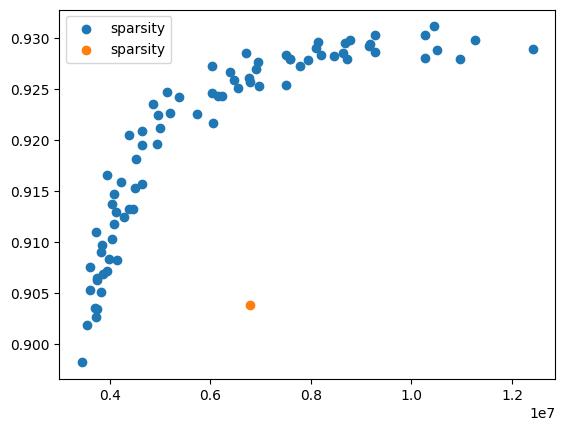

In [116]:
plt.scatter(nspikes_sparsity , acc_sparsity , label = "sparsity")
plt.scatter(nspikes_synchrony , acc_synchrony , label = "sparsity")

plt.legend()
plt.show()